---
# INTRODUÇÃO

O GeoPandas é um projeto open source que foi criado para tornar a manipulação de dados geoespaciais no Python uma tarefa mais simples. Ele estende as estruturas de dados do Pandas, que são o dataframe e o series, possibilitando a manipulação e tratamento de arquivos dessa natureza.

Além disso, ele possui uma série de dependências importantes, dentre elas: o shapely, que dá suporte a operações geométricas; o fiona, que permite acessar arquivos com informações geográficos; e o Matplotlib (juntamente com o http://localhost:8888/tree), que permite a plotagem de gráficos e figuras geométricas.

## Sequência de Tarefas

**1. Adquirir dados** 
 * Baixar dados do IBGE

> <ftp://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2017/UFs/PA/> 

 ><ftp://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_de_setores_censitarios__divisoes_intramunicipais/censo_2010/>

* Anuário estatístico de Belém  

> <http://anuario.belem.pa.gov.br/>

**2.Manipular e agregar dados**

* Extrair informações básicas dos dados geolocalizados

* Agregar informações externas

* Transformar dados externos em pontos geolocalizados

## Preparar Ambiente

In [1234]:
%matplotlib inline
import geopandas as gpd
import pandas as pd

import numpy as np
from geopandas import GeoSeries
from shapely.geometry import Point

import zipfile
import shutil
import os

import folium
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap

# Disabilitarv avisos
import warnings
warnings.filterwarnings('ignore')

---
# 1. TRABALHANDO COM BANCOS DE DADOS DADOS DO IBGE

O primeiro banco de dados contêm informções geometricas de todas as cidades do estado do Pará, mas como veremos a seguir isso não será o bastante para criar um mapa com a precisão adequada

In [1235]:
# Ler shapefile
ESTADO_PA=gpd.read_file('Mapas/IBGE-PA/15MUE250GC_SIR.shp')
ESTADO_PA.head(10)

,NM_MUNICIP,CD_GEOCMU,geometry
0,ABAETETUBA,1500107,POLYGON ((-48.83138539099997 -1.56352043699993...
1,ABEL FIGUEIREDO,1500131,POLYGON ((-48.56309859599997 -4.82659764899993...
2,ACARÃ,1500206,POLYGON ((-48.30973915899997 -1.47027638799995...
3,AFUÃ,1500305,POLYGON ((-50.50552749999996 0.184213121000048...
4,ÃGUA AZUL DO NORTE,1500347,POLYGON ((-50.81161970799999 -6.27576446300000...
5,ALENQUER,1500404,POLYGON ((-55.36338584699999 1.484887388000047...
6,ALMEIRIM,1500503,POLYGON ((-54.95430669599995 2.583692423000045...
7,ALTAMIRA,1500602,POLYGON ((-52.24437309599995 -2.98871685399998...
8,ANAJÃS,1500701,POLYGON ((-50.11452422599992 -0.46476720299995...
9,ANANINDEUA,1500800,POLYGON ((-48.33465742099999 -1.23983291399994...


**MAPA DO ESTADO DO PARÁ**

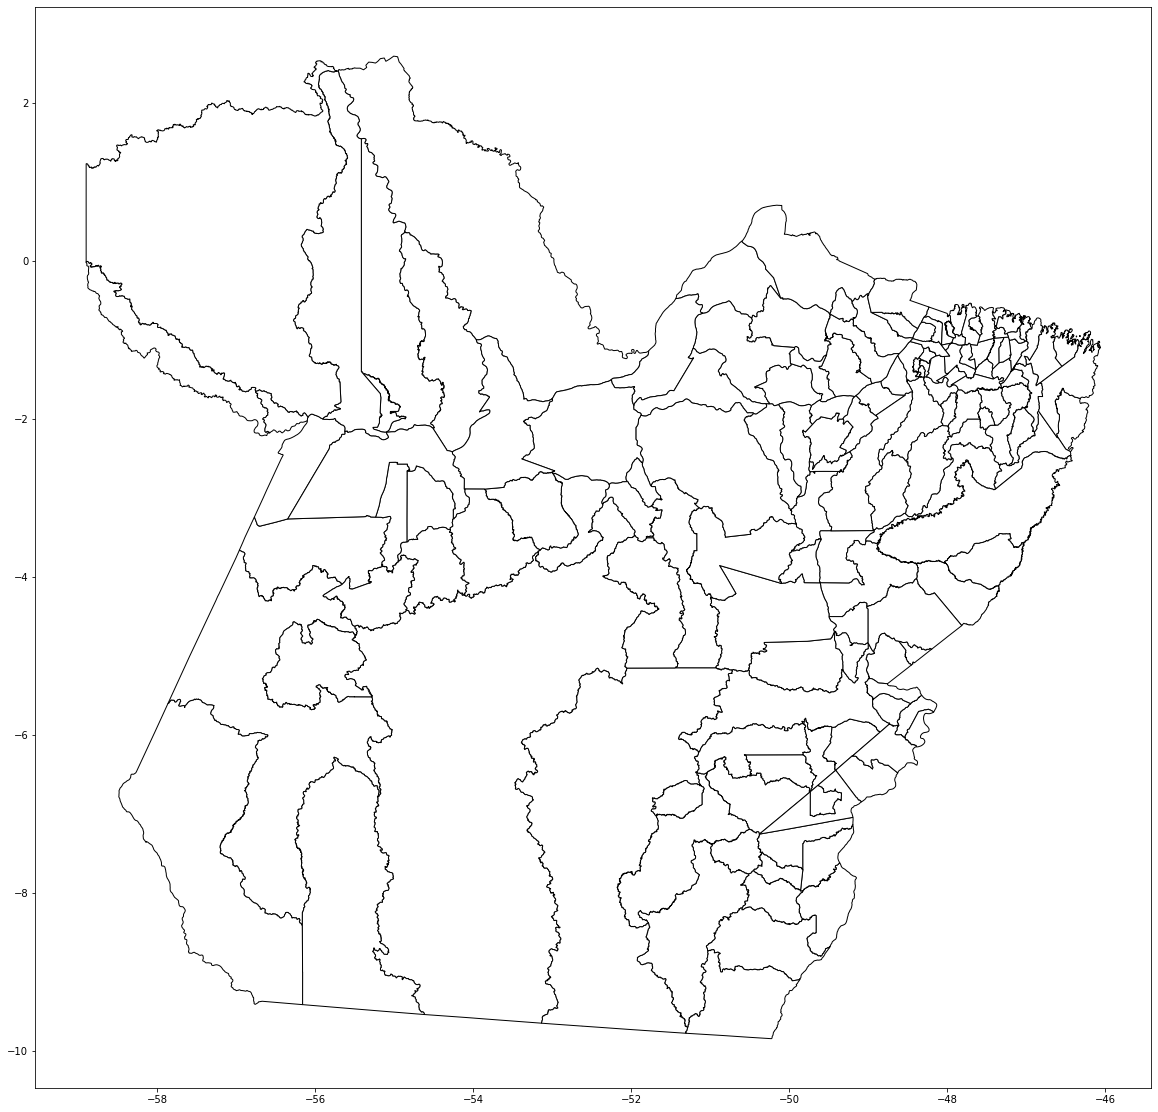

In [1236]:
Mapa_Estado_PA=ESTADO_PA.plot(color='white', edgecolor='black', figsize=(20,20))

**O banco de dados é contem originalmete três colunas:**

  * Nome do município
 
  * Código do município
 
  * Geometria do contorno de cada município
 

In [1237]:
print('No total o banco de dados contem a infomação de',ESTADO_PA.shape[0], 'cidades do estado do Pará')

No total o banco de dados contem a infomação de 144 cidades do estado do Pará


## 1.1.Cidade de Belém

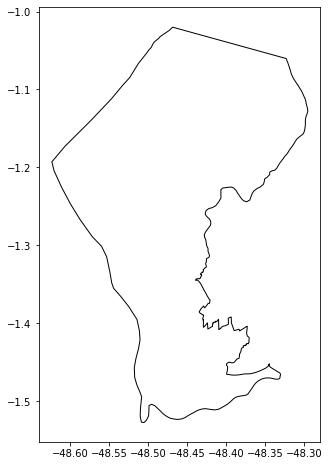

In [1238]:
'''
Dependendo da formatação do encode do compilador o acento no nome das ciades pode ser um problema 
então o ideal e trabalhar com código da cidade
'''

CIDADE_BEL=ESTADO_PA[ESTADO_PA.CD_GEOCMU=='1501402']
Mapa_Cidade_Bel=CIDADE_BEL.plot(color='white', edgecolor='black', figsize=(12,8))

## 1.2.Setores Censitários

O setor censitário é a unidade territorial estabelecida para fins de controle cadastral, formado por área contínua, situada em um único quadro urbano ou rural, com dimensão e número de domicílios que permitam o levantamento por um recenseador

In [1239]:
ESTADO_PA_SETOR=gpd.read_file('Mapas/SETORES/15SEE250GC_SIR.shp')

**MAPA DOS SETORES CENSITÁRIOS DA CIDADE DE BELÉM**

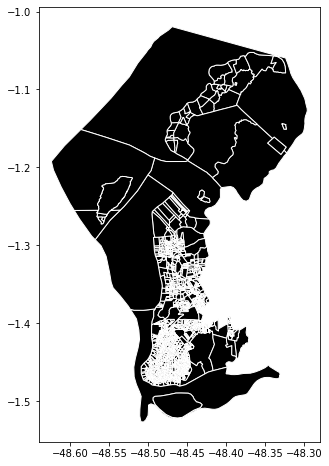

In [1240]:
BELEM=ESTADO_PA_SETOR.CD_GEOCODM=='1501402'
BEL_SETORES=ESTADO_PA_SETOR[BELEM]
Setores_Belem=BEL_SETORES.plot(color='black', edgecolor='white', figsize=(12,8))

**Vale ressaltar que o arquivo original do IBGE agrupa o território da cidade (solo livre , rios e ilhas) em uma coisa só, por isso é importante usar os setores sensitarios. Depois de contastar isso o ideial é separar o setores urabnos e rurais** 

## 1.3.Identificando a Região Urbana da Cidade 

In [1241]:
URBANO=BEL_SETORES.TIPO=='URBANO'
BEL_URBANA=BEL_SETORES[URBANO]
BEL_URBANA.head()

,ID,CD_GEOCODI,TIPO,CD_GEOCODB,NM_BAIRRO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,geometry
15,9851,150140250000020,URBANO,150140250008,Marambaia,15014025000,None,150140250,ENTRONCAMENTO,1501402,BELÉM,BELÉM,METROPOLITANA DE BELÉM,"POLYGON ((-48.46916 -1.40409, -48.469013 -1.40..."
16,9852,150140250000021,URBANO,150140250008,Marambaia,15014025000,None,150140250,ENTRONCAMENTO,1501402,BELÉM,BELÉM,METROPOLITANA DE BELÉM,"POLYGON ((-48.468177 -1.401152, -48.464498 -1...."
17,9853,150140250000022,URBANO,150140250008,Marambaia,15014025000,None,150140250,ENTRONCAMENTO,1501402,BELÉM,BELÉM,METROPOLITANA DE BELÉM,"POLYGON ((-48.46201199999999 -1.396183, -48.46..."
18,9854,150140250000023,URBANO,150140250008,Marambaia,15014025000,None,150140250,ENTRONCAMENTO,1501402,BELÉM,BELÉM,METROPOLITANA DE BELÉM,"POLYGON ((-48.462131 -1.401413, -48.462104 -1...."
19,9855,150140250000024,URBANO,150140250008,Marambaia,15014025000,None,150140250,ENTRONCAMENTO,1501402,BELÉM,BELÉM,METROPOLITANA DE BELÉM,"POLYGON ((-48.459194 -1.40157499999998, -48.45..."


In [1242]:
print('A refião urbana de Belém tem',len(BEL_URBANA.NM_BAIRRO.unique()), 'setores sensitários')

A refião urbana de Belém tem 72 setores sensitários


**MAPA  DOS SETORES URBANOS DA CIDADE DE BELÉM**

Ainda sim a regiões sensitárias ainda são muito densas.Então é ncessario um tramento mais fino para indentificar os bairros

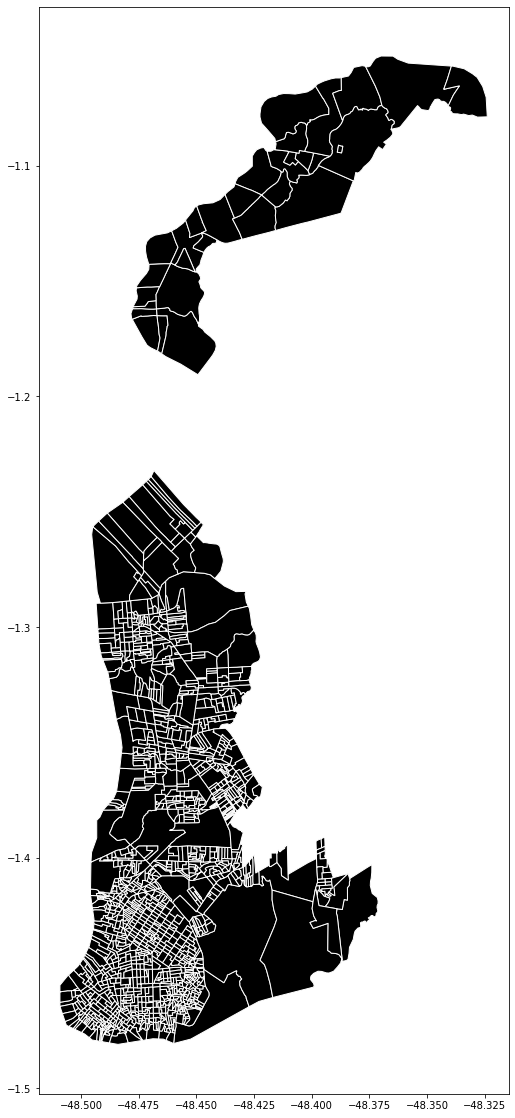

In [1243]:
Setores_Belem=BEL_URBANA.plot(color='black', edgecolor='white', figsize=(12,20))

---
## Extra - Trabalhando com um Bairro 

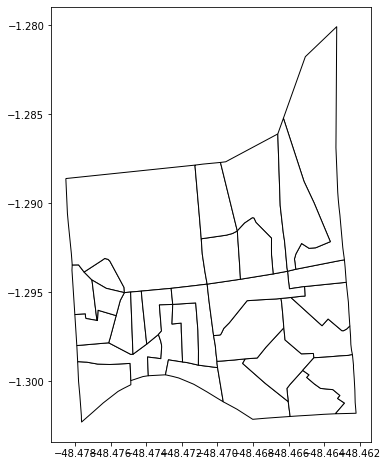

In [1244]:
ICOARACI=BEL_URBANA.query('NM_BAIRRO == "Campina de Icoaraci" ')
ICOARACI.plot(color='white', edgecolor='black', figsize=(15,8))

---
## 1.4.Disolver as Regiões Censitárias em Bairros

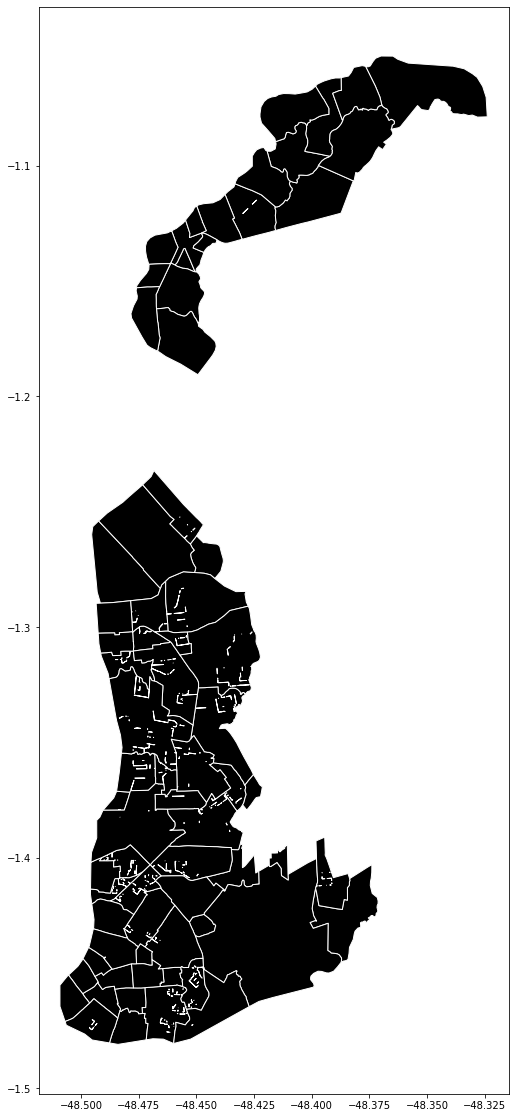

In [1245]:
# Disolver regiões censitárias
BEL_URBANA = BEL_URBANA.to_crs({'init': 'epsg:4326'})
DISOLV = BEL_URBANA[['NM_BAIRRO', 'geometry']]
BAIRROS = DISOLV.dissolve(by='NM_BAIRRO')
Bairros_Bel=BAIRROS.plot(color='black', edgecolor='white', figsize=(12, 20)) 

## 1.5.Extrair informações do *GeoDataFrame*

**ÁREA DOS BAIRROS**

<http://www.belem.pa.gov.br/app/ANUARIO_2011/1_01_Caracterizacao%20do%20Territorio.pdf>

In [1246]:
BAIRROS=BAIRROS.to_crs('+proj=utm +zone=23 +south +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=km +no_defs')
BAIRROS['AREA_Km2']=BAIRROS.area
BAIRROS.head()

,geometry,AREA_Km2
NM_BAIRRO,,
Aeroporto,"POLYGON ((115.8808180578753 9873.099855006054,...",0.482702
Agulha,"POLYGON ((112.9229288244083 9854.888873182706,...",1.305018
Arirambá,"POLYGON ((119.0923554691294 9876.789211550924,...",4.270125
Aurá,"POLYGON ((121.6237110062746 9842.873413329638,...",6.510607
Barreiro,"POLYGON ((111.9845190674648 9842.960203227678,...",1.134012


## 1.6.Salvando dados tratados

In [1247]:
# Criar diretótrios de armazenamento
dir_1='Mapas/BELEM'

if not os.path.exists(dir_1):
    os.makedirs(dir_1)
    
# Salvar região urbana 
BEL_URBANA.to_file(dir_1+'/BEL_URBANA.shp')

**SALVAR INFORMAÇÕES DE TODOS OS BAIRROS**

In [1248]:
# Salvar região divididade em bairros 
dir_2='Mapas/BELEM/BAIRROS'
if not os.path.exists(dir_2):
    os.makedirs(dir_2)
    
BAIRROS.to_file(dir_2+'/TODOS_BAIRROS.shp')

# O dataframe vem sem index numérico , nesse caso isso é um problema
BAIRROS.head(10)

,geometry,AREA_Km2
NM_BAIRRO,,
Aeroporto,"POLYGON ((115.8808180578753 9873.099855006054,...",0.482702
Agulha,"POLYGON ((112.9229288244083 9854.888873182706,...",1.305018
Arirambá,"POLYGON ((119.0923554691294 9876.789211550924,...",4.270125
Aurá,"POLYGON ((121.6237110062746 9842.873413329638,...",6.510607
Barreiro,"POLYGON ((111.9845190674648 9842.960203227678,...",1.134012
Batista Campos,"POLYGON ((110.9558302996639 9838.103559221394,...",1.436436
Baía do Sol,"POLYGON ((124.1071398123461 9882.976505179924,...",12.157005
Bengui,"POLYGON ((116.4221578427068 9847.69634140687, ...",1.924700
Bonfim,"POLYGON ((119.768115027649 9876.22196964461, 1...",6.871272


In [1249]:
# Salvar a geomtria de todos os bairros de forma individual 

Nomes_Bairros=BEL_URBANA.NM_BAIRRO.unique()
for Bairro in Nomes_Bairros:
    
    nome_arquivo=dir_2+'/'+Bairro+'.shp'
    BAIRRO_ATUAL=BEL_URBANA[BEL_URBANA.NM_BAIRRO==Bairro]
    BAIRRO_ATUAL.to_file(nome_arquivo)
    
    #print(nome_arquivo)

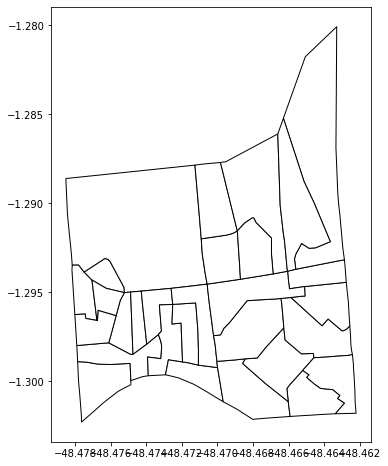

In [1250]:
# Testar 
TESTE=gpd.read_file('Mapas/BELEM/BAIRROS/Campina de Icoaraci.shp')
Verficar=TESTE.plot(color='white', edgecolor='black', figsize=(12,8))

---
# 2. AGREGANDO DADOS DA PREFEITURA E CRIANDO LAYERS

In [1251]:
demografico = pd.read_excel('Dados Gerais\BAIRROS_DADOS_AGREGADOS.xlsx')
demografico =demografico.set_index('NM_BAIRRO')
demografico =demografico.sort_values('NM_BAIRRO')
demografico=demografico.reset_index()
demografico.head(10)

,NM_BAIRRO,POP_H,POP_M,POP_TOTAL
0,Aeroporto,584,586,1170
1,Agulha,9576,10136,19712
2,Arirambá,951,991,1942
3,Aurá,918,909,1827
4,Barreiro,12700,13303,26003
5,Batista Campos,8265,10871,19136
6,Baía do Sol,1247,1167,2414
7,Bengui,14017,15362,29379
8,Bonfim,410,366,776
9,Brasília,2995,3024,6019


## 2.1.Agregar informações

In [1252]:
# Detacar que bairro do Curió Utinga está reptido mas não com o exato mesmo nome
BAIRROS=BAIRROS.sort_values('NM_BAIRRO')
BAIRROS=BAIRROS.reset_index()

BAIRROS['POP_H']=demografico.POP_H
BAIRROS['POP_M']=demografico.POP_M
BAIRROS['POP_TOTAL']=demografico.POP_TOTAL
BAIRROS['DENSIDADE']=demografico.POP_TOTAL/BAIRROS.AREA_Km2

BAIRROS.head(10)

,NM_BAIRRO,geometry,AREA_Km2,POP_H,POP_M,POP_TOTAL,DENSIDADE
0,Aeroporto,"POLYGON ((115.8808180578753 9873.099855006054,...",0.482702,584,586,1170,2423.853387
1,Agulha,"POLYGON ((112.9229288244083 9854.888873182706,...",1.305018,9576,10136,19712,15104.771980
2,Arirambá,"POLYGON ((119.0923554691294 9876.789211550924,...",4.270125,951,991,1942,454.787578
3,Aurá,"POLYGON ((121.6237110062746 9842.873413329638,...",6.510607,918,909,1827,280.618991
4,Barreiro,"POLYGON ((111.9845190674648 9842.960203227678,...",1.134012,12700,13303,26003,22930.096549
5,Batista Campos,"POLYGON ((110.9558302996639 9838.103559221394,...",1.436436,8265,10871,19136,13321.862551
6,Baía do Sol,"POLYGON ((124.1071398123461 9882.976505179924,...",12.157005,1247,1167,2414,198.568649
7,Bengui,"POLYGON ((116.4221578427068 9847.69634140687, ...",1.924700,14017,15362,29379,15264.195068
8,Bonfim,"POLYGON ((119.768115027649 9876.22196964461, 1...",6.871272,410,366,776,112.933965
9,Brasília,"POLYGON ((113.4072166527683 9858.775692010258,...",7.317191,2995,3024,6019,822.583463


In [1253]:
BAIRROS.set_index('NM_BAIRRO')
BAIRROS.head(10)

,NM_BAIRRO,geometry,AREA_Km2,POP_H,POP_M,POP_TOTAL,DENSIDADE
0,Aeroporto,"POLYGON ((115.8808180578753 9873.099855006054,...",0.482702,584,586,1170,2423.853387
1,Agulha,"POLYGON ((112.9229288244083 9854.888873182706,...",1.305018,9576,10136,19712,15104.771980
2,Arirambá,"POLYGON ((119.0923554691294 9876.789211550924,...",4.270125,951,991,1942,454.787578
3,Aurá,"POLYGON ((121.6237110062746 9842.873413329638,...",6.510607,918,909,1827,280.618991
4,Barreiro,"POLYGON ((111.9845190674648 9842.960203227678,...",1.134012,12700,13303,26003,22930.096549
5,Batista Campos,"POLYGON ((110.9558302996639 9838.103559221394,...",1.436436,8265,10871,19136,13321.862551
6,Baía do Sol,"POLYGON ((124.1071398123461 9882.976505179924,...",12.157005,1247,1167,2414,198.568649
7,Bengui,"POLYGON ((116.4221578427068 9847.69634140687, ...",1.924700,14017,15362,29379,15264.195068
8,Bonfim,"POLYGON ((119.768115027649 9876.22196964461, 1...",6.871272,410,366,776,112.933965
9,Brasília,"POLYGON ((113.4072166527683 9858.775692010258,...",7.317191,2995,3024,6019,822.583463


**SALVAR INFORMÇAÕES EM EXCEL**

In [1254]:
dir_3='Dados Gerais'
BEL_URBANA.to_excel(dir_3+'/BELEM_URBANA.xlsx')
BAIRROS.to_excel(dir_3+'/BAIRROS.xlsx')

## 2.2. Camadas

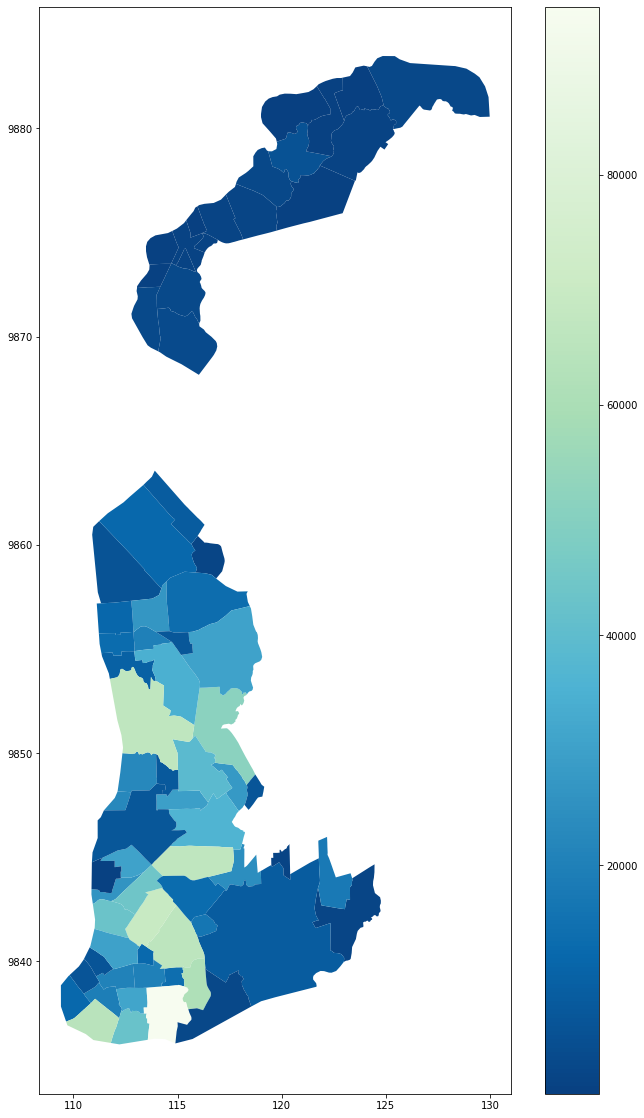

In [1255]:
# MAPA BASE POPULACIONAL DE HOMENS
Base_Pop_Ho=BAIRROS.plot(column='POP_TOTAL',legend=True,cmap='GnBu_r',figsize=(12,20))

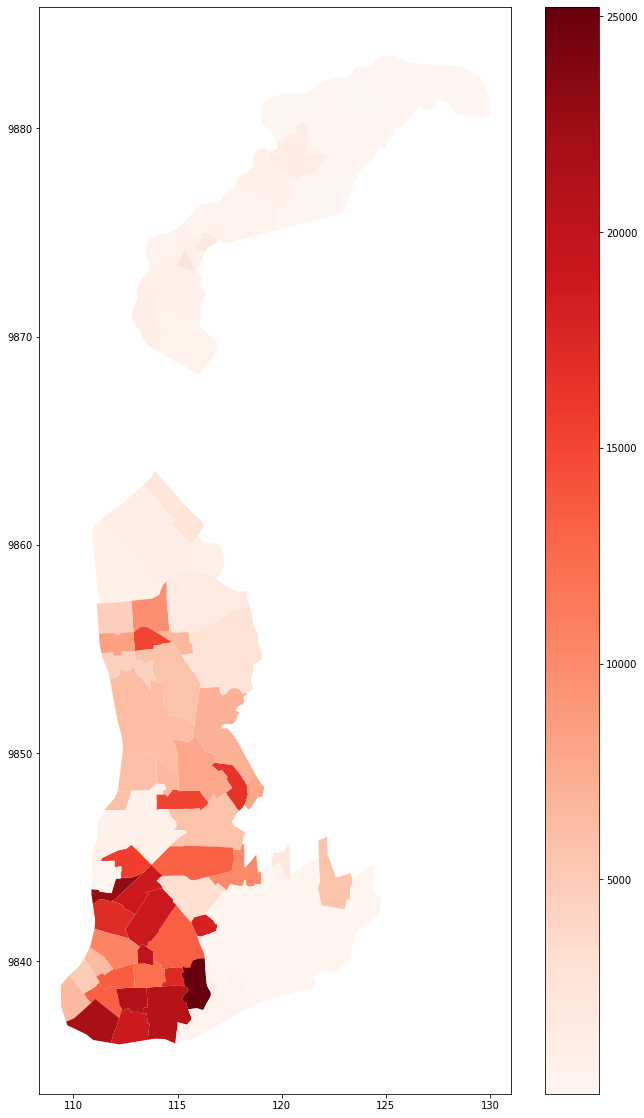

In [1256]:
# DENSIDADE POPULACIONAL
Base_Den=BAIRROS.plot(column='DENSIDADE',legend=True,cmap='Reds',figsize=(12,20))

# 3. COBINAR INFORMAÇÕES GEOLOCALIZADAS

## 3.1.Pontos de Interesse

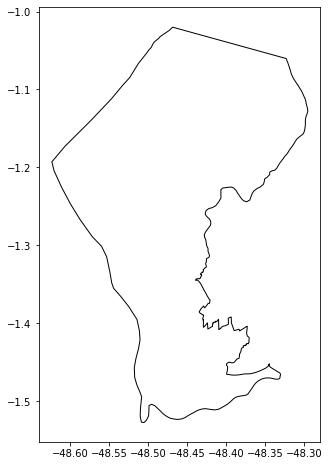

In [1257]:
#Cidade de belém sem tratamento
Mapa_Cidade_Bel.get_figure()

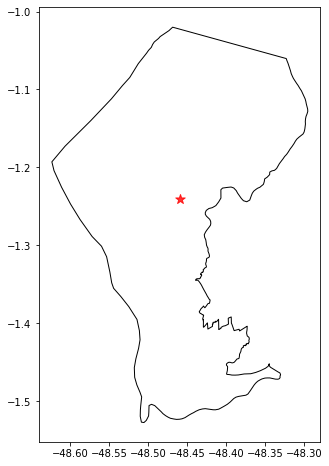

In [1258]:
# Centroide da cidade
base=CIDADE_BEL.plot(color='white', edgecolor='black', figsize=(12,8))
centroide=CIDADE_BEL.centroid
Mapa_Cobinado=centroide.plot(ax=base,marker='*',
                             color='red',
                             alpha=0.8,
                             markersize=100)

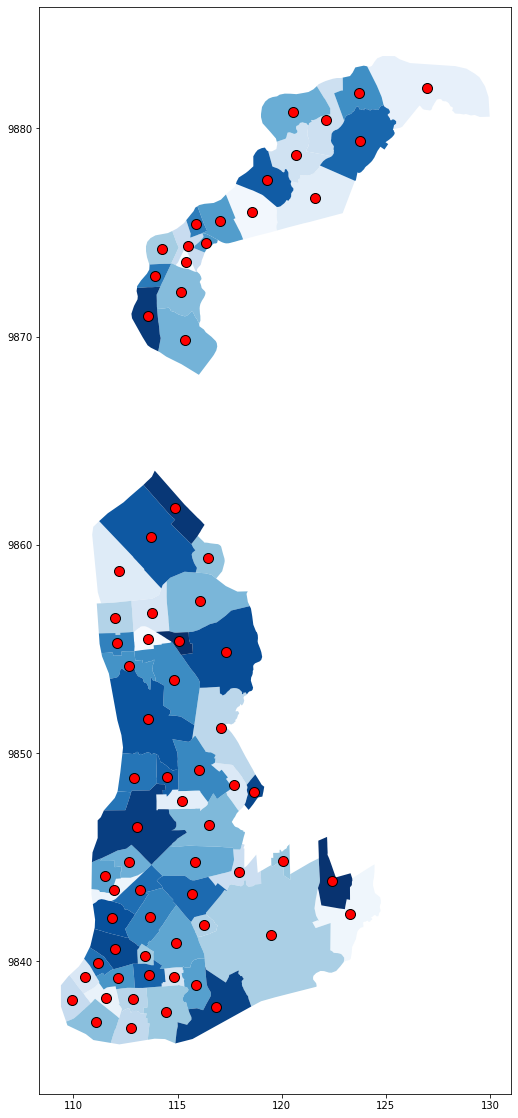

In [1259]:
#Centroide de todos os bairros 
base=BAIRROS.plot(cmap='Blues', figsize=(12,20))
centroides=BAIRROS.centroid
Mapa_Cobinado=centroides.plot(ax=base,marker='o',
                             color='red',
                             edgecolor='black',
                             alpha=1,
                             markersize=100)

In [1260]:
# Adicionar centroides no data frame bairros
BAIRROS['CENTROIDE']=centroides
BAIRROS.head()

,NM_BAIRRO,geometry,AREA_Km2,POP_H,POP_M,POP_TOTAL,DENSIDADE,CENTROIDE
0,Aeroporto,"POLYGON ((115.8808180578753 9873.099855006054,...",0.482702,584,586,1170,2423.853387,POINT (115.3913568902958 9873.593580209917)
1,Agulha,"POLYGON ((112.9229288244083 9854.888873182706,...",1.305018,9576,10136,19712,15104.771980,POINT (113.5687061885793 9855.470854186522)
2,Arirambá,"POLYGON ((119.0923554691294 9876.789211550924,...",4.270125,951,991,1942,454.787578,POINT (118.5905115098736 9875.970907521885)
3,Aurá,"POLYGON ((121.6237110062746 9842.873413329638,...",6.510607,918,909,1827,280.618991,POINT (123.2822101431243 9842.286654297521)
4,Barreiro,"POLYGON ((111.9845190674648 9842.960203227678,...",1.134012,12700,13303,26003,22930.096549,POINT (111.9485191969311 9843.433511547786)


## 3.2.Pontos de referência

In [1261]:
shoppings = pd.read_excel('Dados Gerais\SHOP.xlsx')
dados=shoppings
dados.head()

,Nome,Classe,Bairro,Latitude,Longitude
0,Parque Shopping,Comercial,Bengui,-1.370256,-48.446128
1,Grao Para,Comercial,Val de Caes,-1.389233,-48.464679
2,Castanheira,Comercial,Atalaia,-1.403070,-48.431005
3,IT Center,Comercial,Sacramenta,-1.416640,-48.479072
4,Boulevard,Comercial,Umarizal,-1.416640,-48.479072


**TRANSFORMAR DATAFRAME EM GEODATAFRAME**

In [1262]:
# Criar geo data frame
x=zip(dados.Longitude,dados.Latitude)
#
crs = {'proj': 'latlong', 'ellps': 'WGS84', 'datum': 'WGS84', 'no_defs': True}
geometry=[Point(x) for x in zip(dados.Longitude,dados.Latitude) ]
#
geo_dados=gpd.GeoDataFrame(dados,crs=crs,geometry=geometry)
geo_dados.head()

,Nome,Classe,Bairro,Latitude,Longitude,geometry
0,Parque Shopping,Comercial,Bengui,-1.370256,-48.446128,POINT (-48.446128 -1.370256)
1,Grao Para,Comercial,Val de Caes,-1.389233,-48.464679,POINT (-48.464679 -1.389233)
2,Castanheira,Comercial,Atalaia,-1.403070,-48.431005,POINT (-48.431005 -1.40307)
3,IT Center,Comercial,Sacramenta,-1.416640,-48.479072,POINT (-48.479072 -1.41664)
4,Boulevard,Comercial,Umarizal,-1.416640,-48.479072,POINT (-48.479072 -1.41664)


## 3.2.Igualar o crs do *data frames*

O CRS (ou "sistema de referência de coordenadas") é uma forma padronizada de escrever as localizações no globo terrestre. Existe mais de um CRS, e sua escolha depende de um conjunto de fatores, como a abrangência geográfica ou mesmo em que época os dados foram coletados. Quando queremos comparar conjuntos de dados com CRSs diferentes, é importante estabelecer um CRS em comum entre eles para torná-los comparáveis - e aprenderemos a fazer isso no futuro.
Existem três parâmetros que, geralmente, aparecem na maioria das configurações de CRS:

**crs = {'proj':'latlong','ellps':'WGS84'.'datum':'WGS84'}** 

Essa é, inclusive, a configuração que utilizamos no nosso projeto

In [1263]:
#Mudar crs do municipio

CIDADE_BEL = CIDADE_BEL.to_crs('+proj=utm +zone=23 +south +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=km +no_defs')
BAIRROS=BAIRROS.to_crs('+proj=utm +zone=23 +south +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=km +no_defs')
geo_dados = geo_dados.to_crs('+proj=utm +zone=23 +south +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=km +no_defs')

## 3.3.Elimiar informações que estejam fora do contorno do município

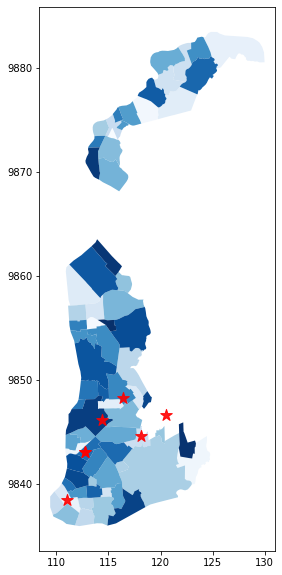

In [1264]:
base=BAIRROS.plot(cmap='Blues', figsize=(10,10))
Mapa_Combinado=geo_dados.plot(ax=base,marker='*',color='red',alpha=0.9,markersize=150)

In [1265]:
# Propiedades da geometria
CIDADE_BEL.geometry

18    POLYGON ((126.7599418992319 9864.806813716588,...
Name: geometry, dtype: object

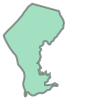

In [1266]:
# Limites da cidade
CIDADE_BEL.iloc[0].geometry

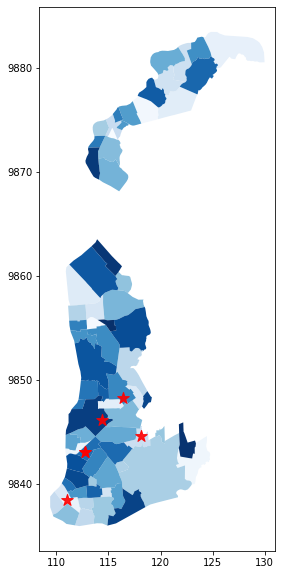

In [1267]:
#Elimnar pontos fora do limite da cidade
geo_dados=geo_dados[geo_dados['geometry'].within(CIDADE_BEL.iloc[0].geometry)]
base=BAIRROS.plot(cmap='Blues', figsize=(10,10))
Mapa_Combinado=geo_dados.plot(ax=base,marker='*',color='red',alpha=0.9,markersize=150)

## 3.4.Criando Pontos Aletórios

In [1268]:
#Criar pontos a parti dos maiximos e miníoms dos limites 
np.random.RandomState(42)

xmin, xmax, ymin, ymax = -48.412635,-48.506413,-1.47818,-1.055735 
Longitude = (xmax - xmin) * np.random.random(2000) + xmin
Latitude =  (ymax - ymin) * np.random.random(2000) + ymin

# Tranformar pontos em Dataframe
dic = {'Longitude':Longitude , 'Latitude': Latitude}
dados = pd.DataFrame(data=dic)
dados.head()

# Criar geo data frame
from shapely.geometry import Point
x=zip(dados.Longitude,dados.Latitude)
#
crs = {'proj': 'latlong', 'ellps': 'WGS84', 'datum': 'WGS84', 'no_defs': True}
geometry=[Point(x) for x in zip(dados.Longitude,dados.Latitude) ]
#
DADOS_ALE=gpd.GeoDataFrame(dados,crs=crs,geometry=geometry)
DADOS_ALE.head()

,Longitude,Latitude,geometry
0,-48.484584,-1.067586,POINT (-48.48458402851328 -1.067586166507501)
1,-48.479125,-1.132247,POINT (-48.47912478604325 -1.132246896408203)
2,-48.500517,-1.431096,POINT (-48.50051678625669 -1.431095788884182)
3,-48.413982,-1.352351,POINT (-48.41398190002732 -1.352350943280207)
4,-48.435277,-1.138303,POINT (-48.43527736900855 -1.138302523399552)


**SEGUIR PASSOS ANTERIORES**

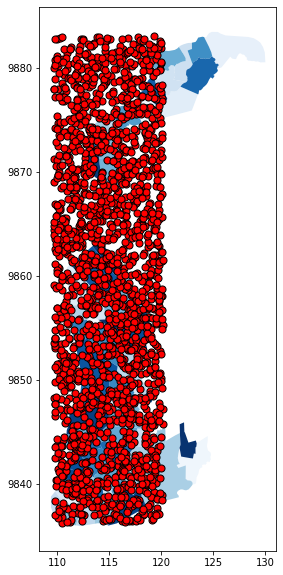

In [1269]:
#Convereter crs
DADOS_ALE = DADOS_ALE.to_crs('+proj=utm +zone=23 +south +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=km +no_defs')

base=BAIRROS.plot(cmap='Blues', figsize=(12,10))
Mapa_Cobinado=DADOS_ALE.plot(ax=base,marker='o',color='red',edgecolor='black',alpha=1,markersize=50)

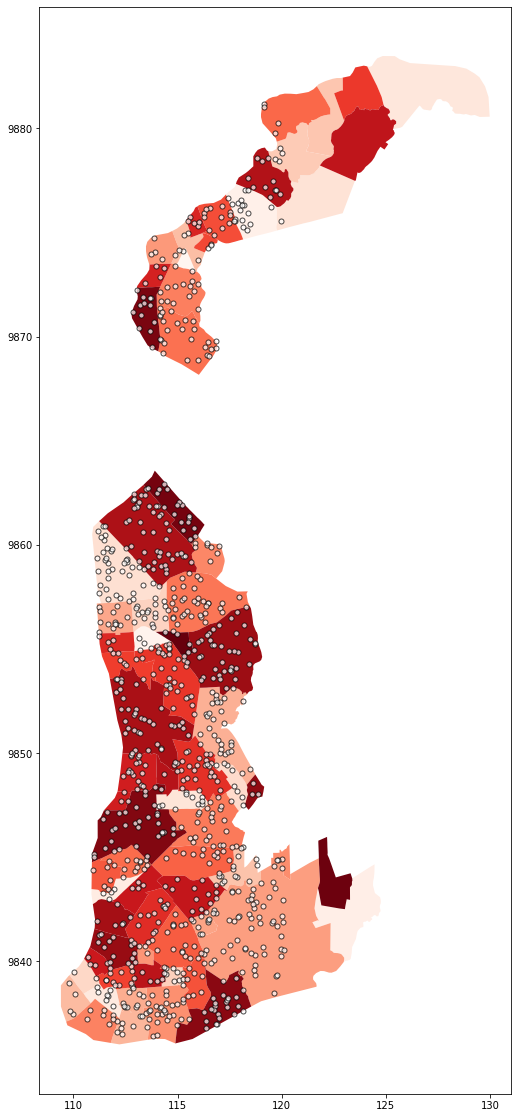

In [1140]:
# Eliminar pontos fora dos liites da cidade
PONTOS_VALIDOS=DADOS_ALE[DADOS_ALE['geometry'].within(BAIRROS.iloc[0].geometry)]
for i in range(1,len(BAIRROS)):
    ATUAL=DADOS_ALE[DADOS_ALE['geometry'].within(BAIRROS.iloc[i].geometry)]
    PONTOS_VALIDOS=PONTOS_VALIDOS.append(ATUAL)
    
base=BAIRROS.plot(cmap='Reds', figsize=(12,20))
Mapa_Combinado=PONTOS_VALIDOS.plot(ax=base,marker='o',color='white',edgecolor='black',alpha=0.7,markersize=25)

## 3.5.Combinando Pontos

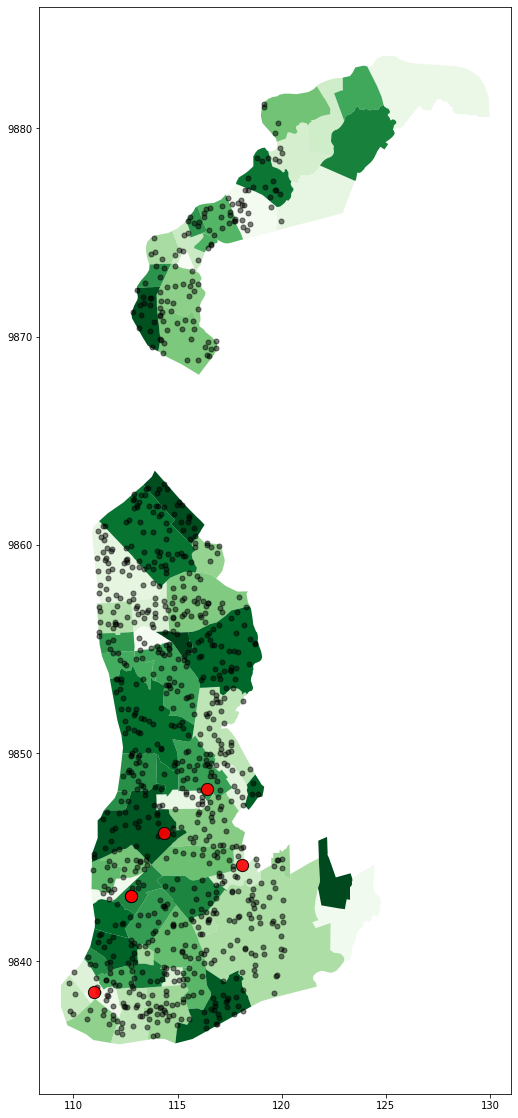

In [1270]:
base=BAIRROS.plot(cmap='Greens', figsize=(12,20))
COMB1=PONTOS_VALIDOS.plot(ax=base,marker='o',color='k',edgecolor='k',alpha=0.5,markersize=25)
COMB2=geo_dados.plot(ax=base,marker='o',color='red',edgecolor='k',alpha=0.9,markersize=150)

# 4.RECURSOS DE EXIBIÇÃO AVANÇADA (FOLIUM)

O propósito dessa biblioteca é unir o poder de manipulação de dados que Python possui com a força de visualização de mapas da biblioteca JavaScript Leaflet. A ideia aqui é tornar ainda mais fácil a missão de colocar pontos em um mapa.

## 4.1.Mapa sem Camadas

In [1276]:
# 1.Definir uma base
BELEM = CIDADE_BEL

# 2.Redefinir crs como orginal
crs = {'init': 'epsg:4326'}
BELEM .to_crs(crs,inplace=True)

# 3.Cacular centroide
y=BELEM.centroid.y.iloc[0]
x=BELEM.centroid.x.iloc[0]

# 4.Criar mapa interativo

base = folium.Map([y, x], zoom_start=11, tiles='OpenStreetMap')
base.choropleth(BELEM)
base

# 4.2.Mapas com Camadas

In [1143]:
# Mapa com label simples (Click)
base = folium.Map([y, x], zoom_start=11, tiles='OpenStreetMap')

geojson_rj = folium(BAIRROS)
base.choropleth(BELEM,'BELEM')

geojson_rj.add_child(folium.Popup('BELÉM'))
geojson_rj.add_to(base)
base

TypeError: 'module' object is not callable

In [ ]:
#Coverter crs do bairro
BAIRROS.to_crs(crs, inplace=True)

#Mapa base
base = folium.Map([y, x], zoom_start=11, tiles='OpenStreetMap')

for i in range(len(BAIRROS)):
    
     geo = folium.GeoJson(BAIRROS[i: i + 1],name=BAIRROS['NM_BAIRRO'][i])
    
#     label = '{} - {} habitantes'.format(bairro['NM_BAIRRO'][i], bairro['V002'][i])
    
#     folium.Popup(label).add_to(geo)
    
#      geo.add_to(base)
    
# #Controle de camadas    
# folium.LayerControl().add_to(base)

#Exibir
#base

In [ ]:
BAIRROS[0]

In [ ]:

#Salvar
base.save('Bairros (RJ).html')